In [1]:
import os
import math
import optuna
import random
import json
import warnings

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import RobustScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from category_encoders import TargetEncoder

import xgboost as xgboost
import lightgbm as lightgbm
from catboost import CatBoostClassifier
from sklearn import set_config


set_config(transform_output="pandas")
seed = 2026
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
warnings.filterwarnings("ignore")

In [2]:
base_path = '/kaggle/input/playground-series-s6e2'
train_data = pd.read_csv(os.path.join(base_path, 'train.csv'), index_col='id')
test_data = pd.read_csv(os.path.join(base_path, 'test.csv'), index_col='id')
submission = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))
target_col = 'Heart Disease'

In [3]:
train_data.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
id,,,,,,,,,,,,,,
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [4]:
train_data.info()
print('-'*80, end='\n\n')

cat_col_list = []
nom_col_list = []

for _col in train_data.columns:
    if _col == target_col:
        continue
    if train_data[_col].dtype == int:
        if train_data[_col].nunique() < 20:
            cat_col_list.append(_col)
            continue
    nom_col_list.append(_col)

train_data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      630000 non-null  int64  
 1   Sex                      630000 non-null  int64  
 2   Chest pain type          630000 non-null  int64  
 3   BP                       630000 non-null  int64  
 4   Cholesterol              630000 non-null  int64  
 5   FBS over 120             630000 non-null  int64  
 6   EKG results              630000 non-null  int64  
 7   Max HR                   630000 non-null  int64  
 8   Exercise angina          630000 non-null  int64  
 9   ST depression            630000 non-null  float64
 10  Slope of ST              630000 non-null  int64  
 11  Number of vessels fluro  630000 non-null  int64  
 12  Thallium                 630000 non-null  int64  
 13  Heart Disease            630000 non-null  object 
dtypes: float6

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,54.136706,0.714735,3.312752,130.497433,245.011814,0.079987,0.981660,152.816763,0.273725,0.716028,1.455871,0.451040,4.618873
std,8.256301,0.451541,0.851615,14.975802,33.681581,0.271274,0.998783,19.112927,0.445870,0.948472,0.545192,0.798549,1.950007
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,223.000000,0.000000,0.000000,142.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,54.000000,1.000000,4.000000,130.000000,243.000000,0.000000,0.000000,157.000000,0.000000,0.100000,1.000000,0.000000,3.000000
75%,60.000000,1.000000,4.000000,140.000000,269.000000,0.000000,2.000000,166.000000,1.000000,1.400000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


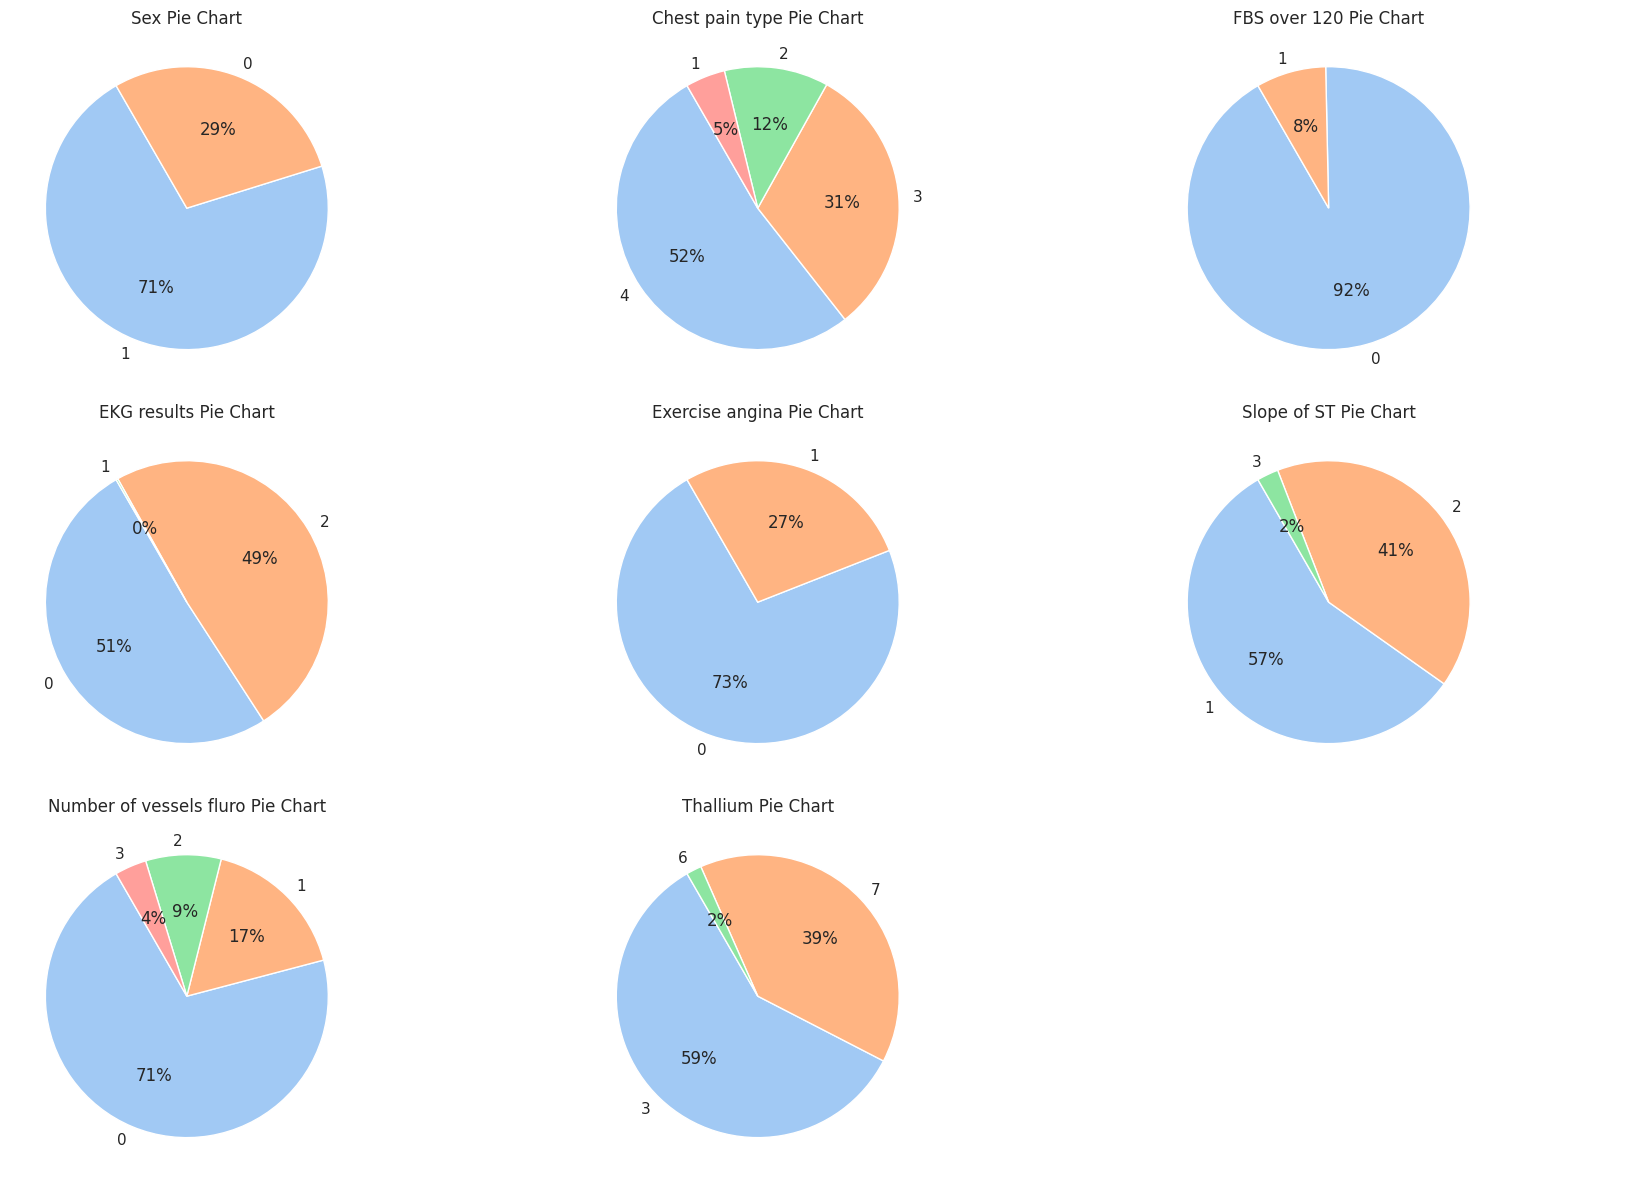

In [5]:
# categorical variable pie chart
sns.set_theme(style="whitegrid")
colors = sns.color_palette('pastel')
fig, axes = plt.subplots(math.ceil(len(cat_col_list)/3), 3, figsize=(18, 12))
axes = axes.flatten()

for _i, _col in enumerate(cat_col_list):
    sample_data = train_data[_col].value_counts(normalize=True)
    axes[_i].pie(sample_data, labels=sample_data.index, colors=colors[:sample_data.__len__()], autopct='%.0f%%', startangle=120)
    axes[_i].set_title(f'{_col} Pie Chart')
for j in range(len(cat_col_list), len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

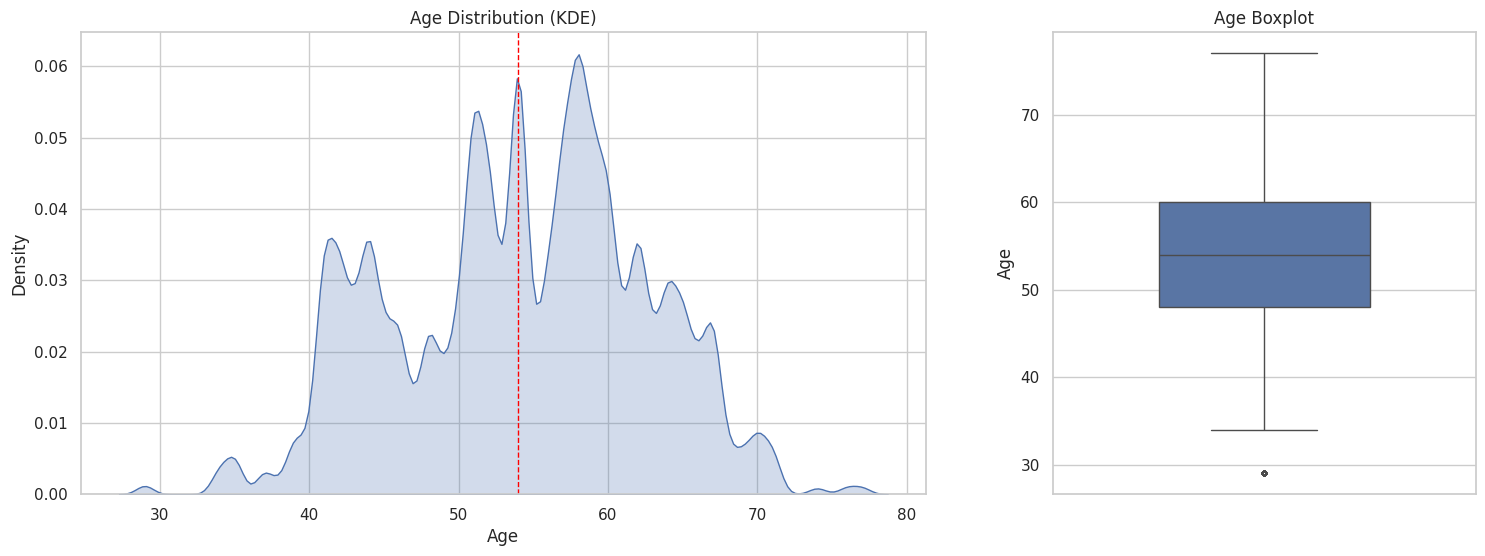

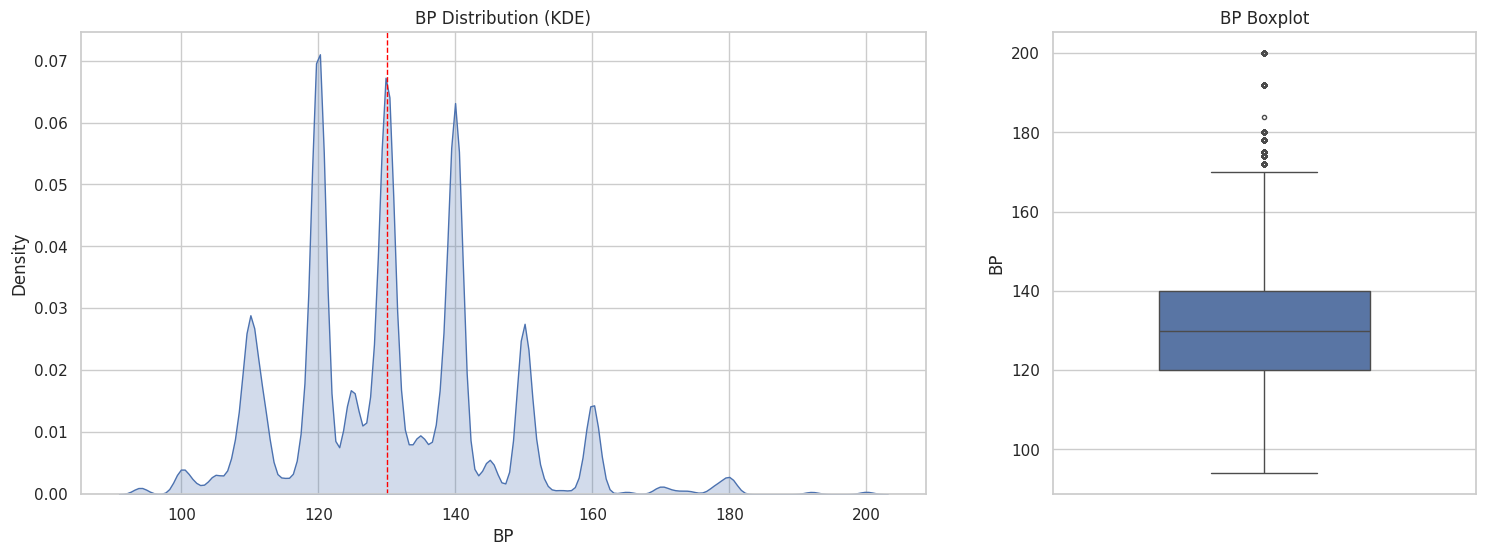

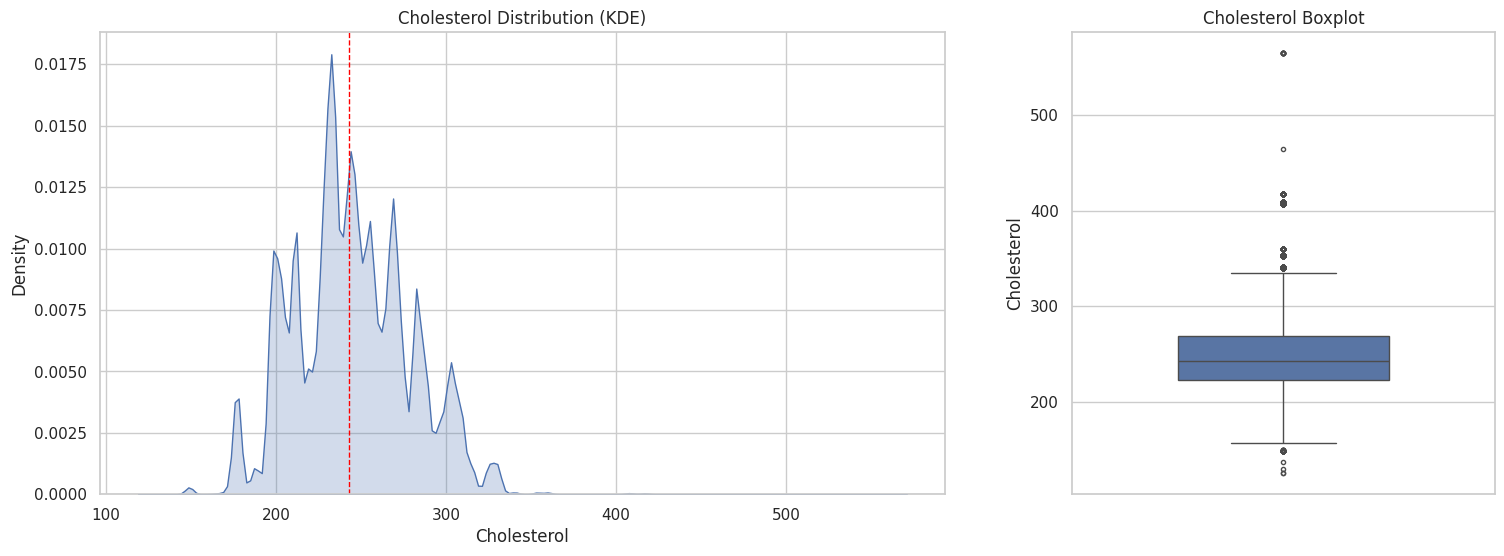

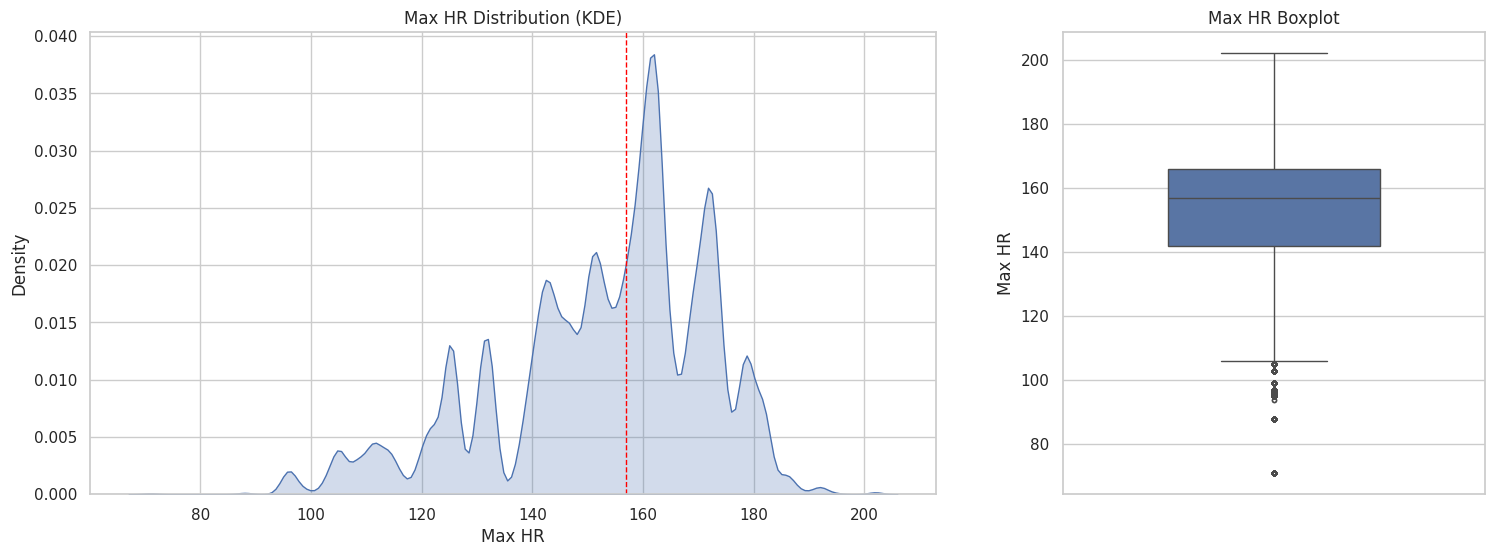

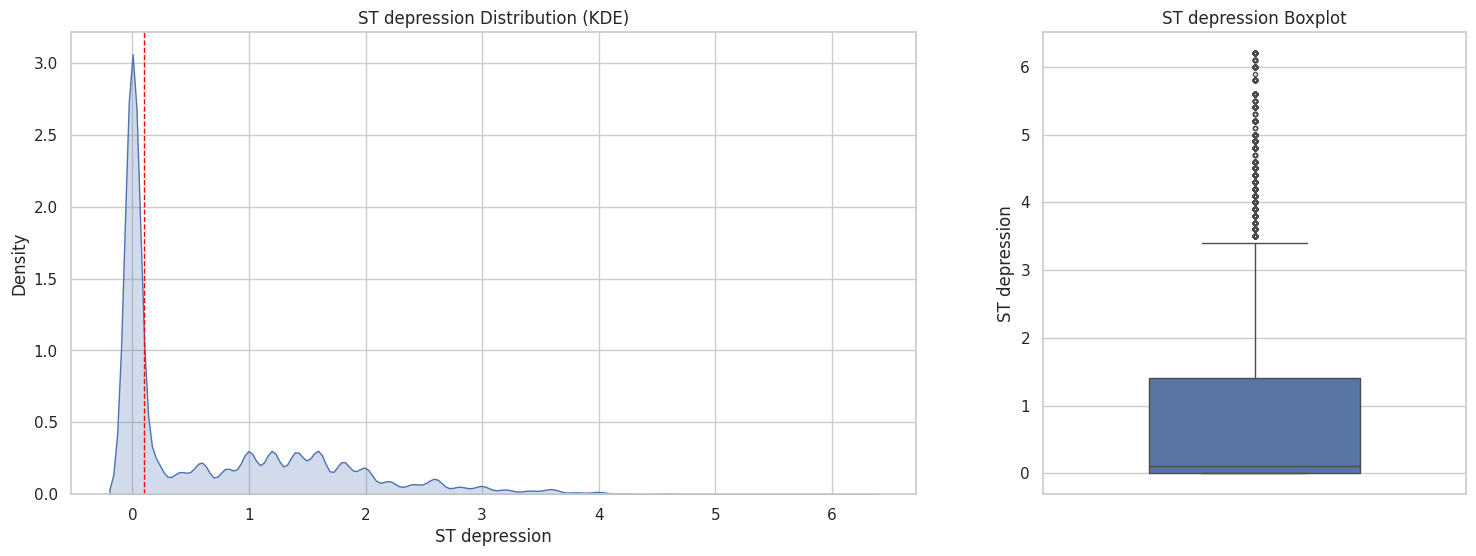

In [6]:
# numerical variable kde-box plot
colors = sns.color_palette('pastel')

# train_data[nom_col_list].hist(bins=100, figsize=(16,12))
for _col in nom_col_list:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1]})
    sns.kdeplot(
        data=train_data, x=_col, ax=axes[0], fill=True)
    mid = train_data[_col].quantile(.5)
    axes[0].set_title(f'{_col} Distribution (KDE)', fontsize=12)
    axes[0].axvline(x=mid, color='red', linestyle='--', linewidth=1, label='midian')
    
    sns.boxplot(
        data=train_data, y=_col, ax=axes[1],
        orient='v', width=0.5, linewidth=1, fliersize=3)
    axes[1].set_title(f'{_col} Boxplot', fontsize=12)

    plt.show()

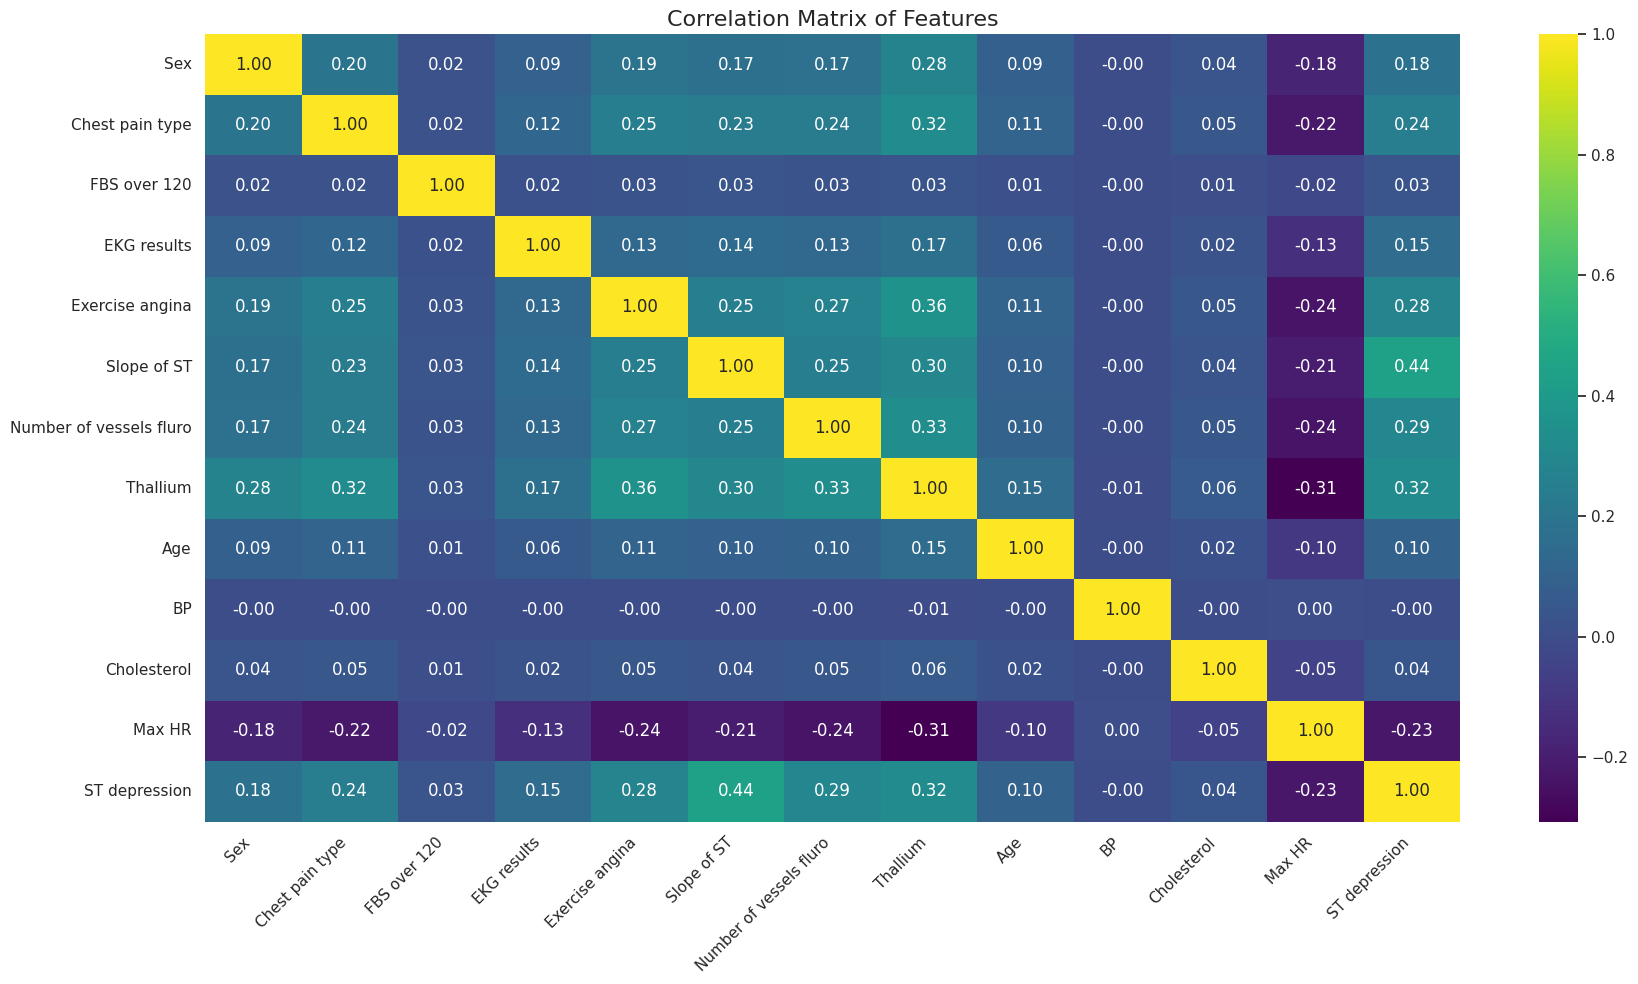

In [7]:
# correlation_matrix
correlation_matrix = train_data[cat_col_list + nom_col_list].corr()
plt.figure(figsize=(18, 10)) 
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Matrix of Features', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

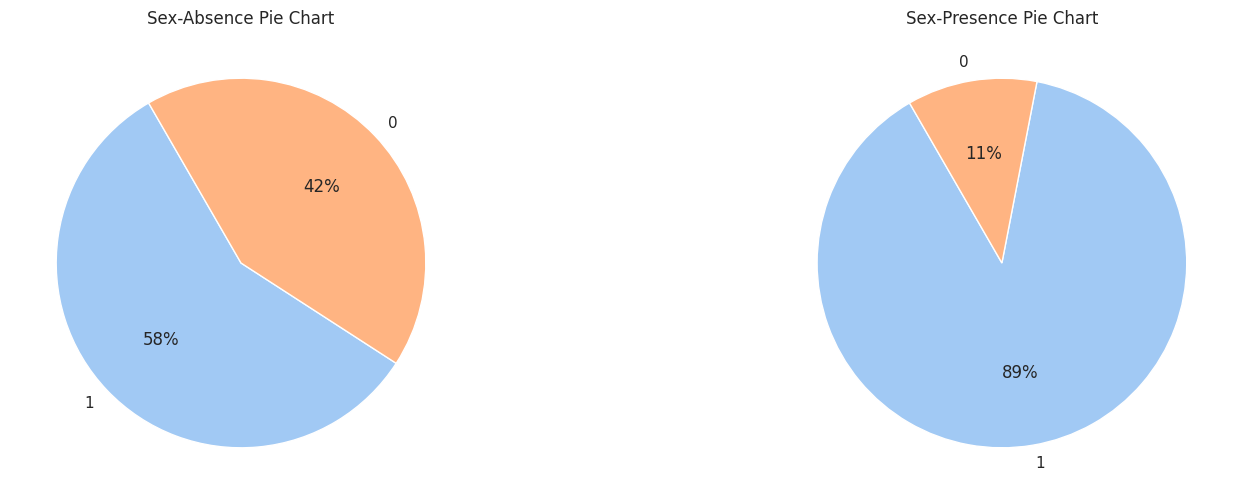

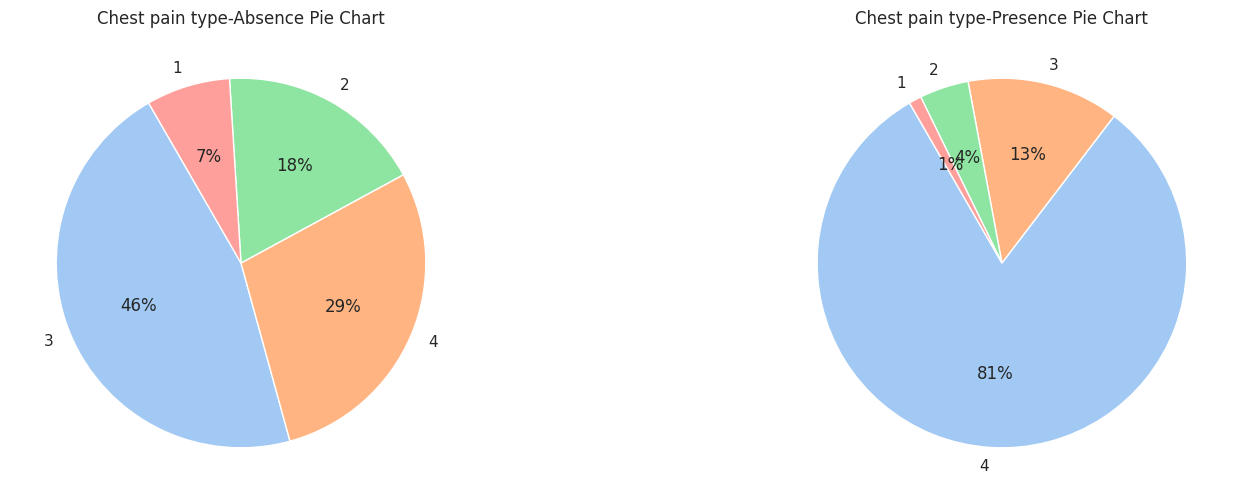

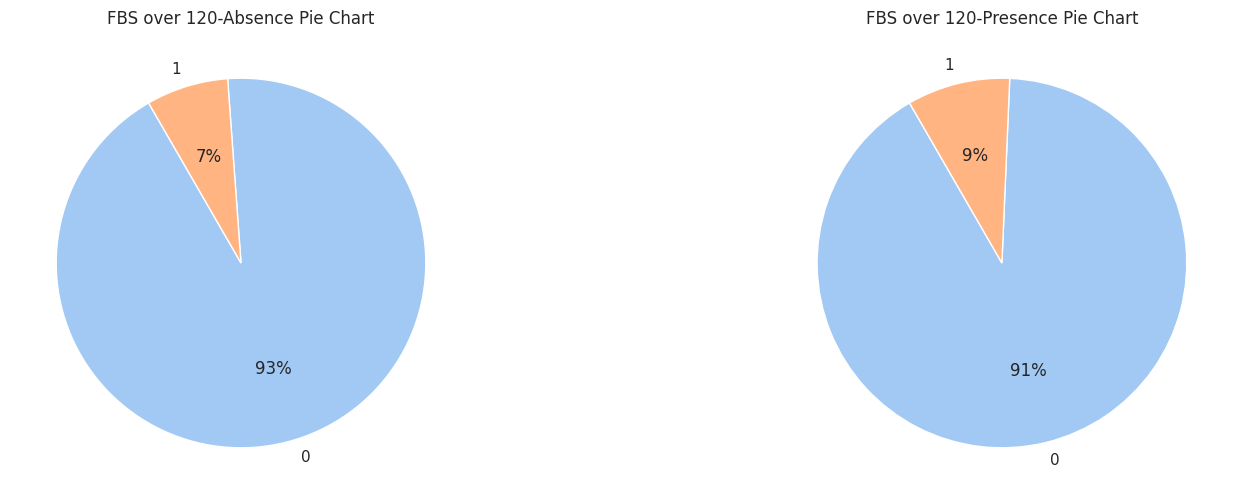

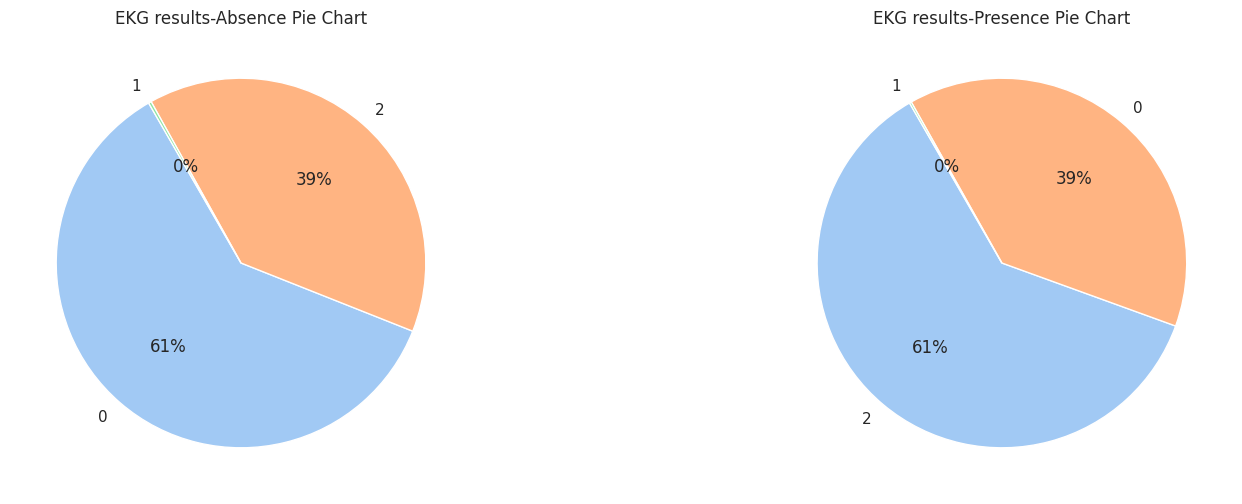

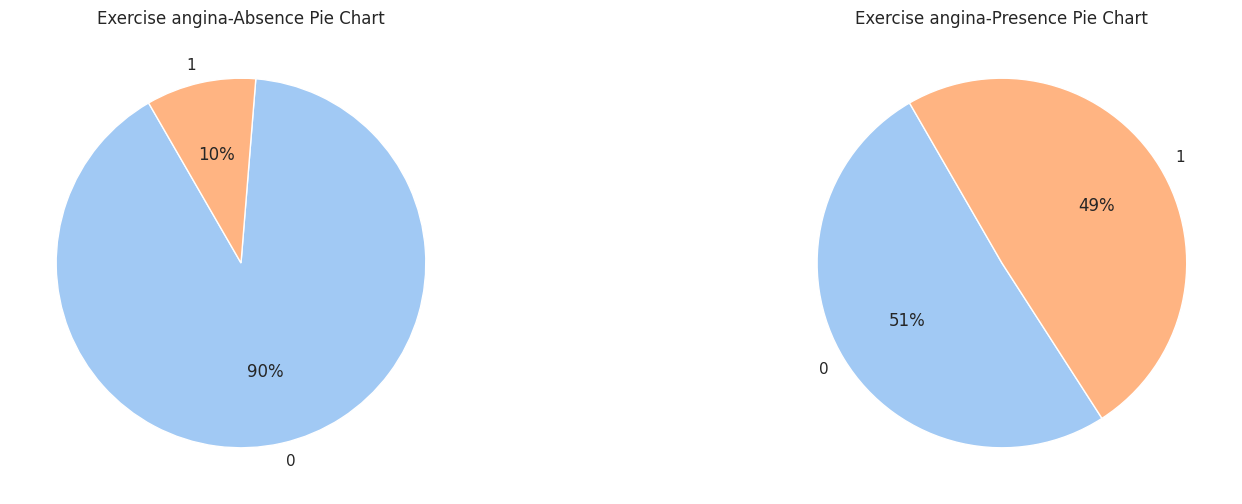

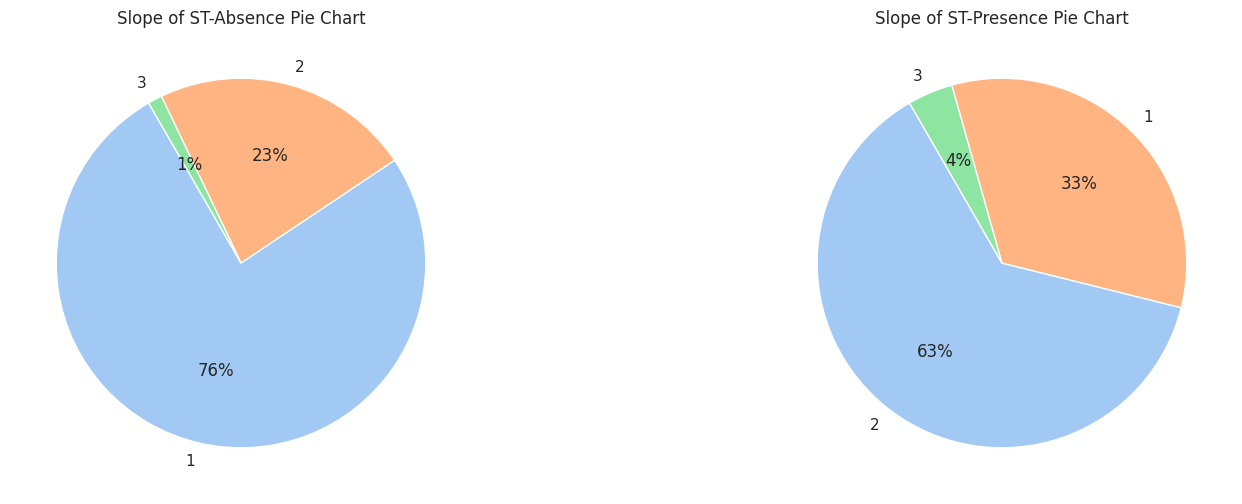

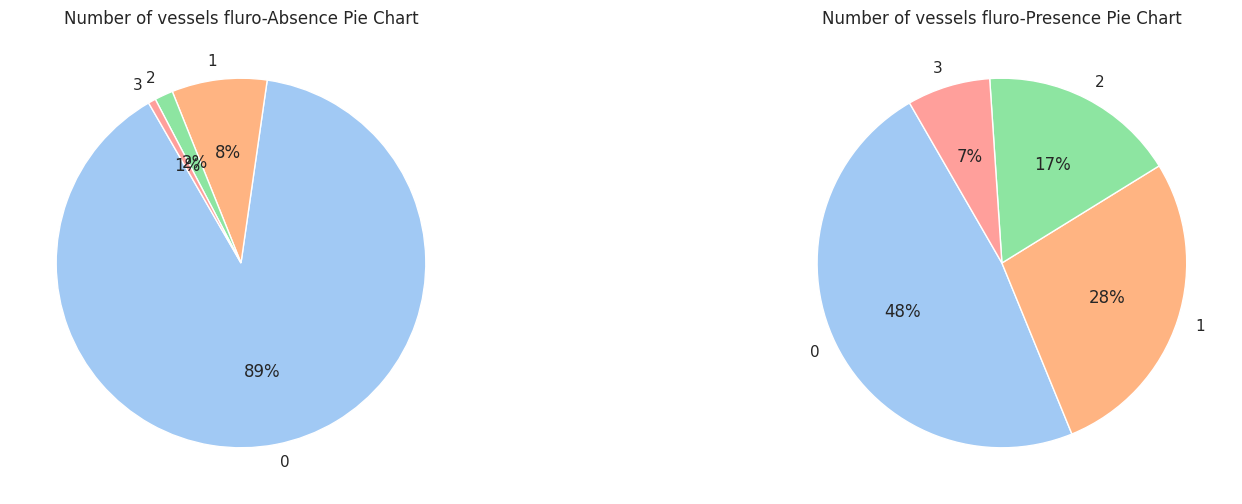

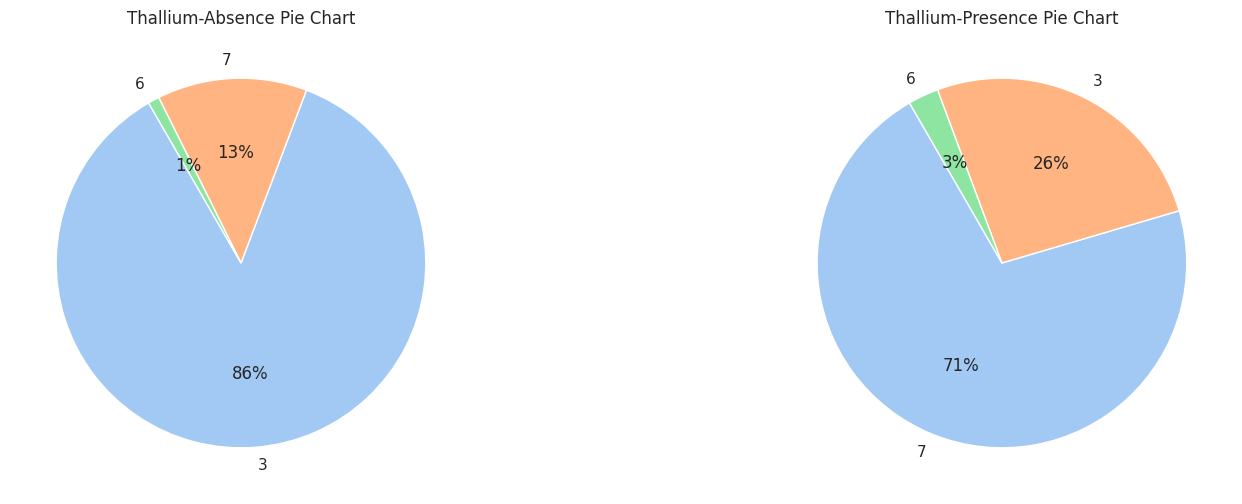

In [8]:
# categorical variable pie chart with target
for _i, _col in enumerate(cat_col_list):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1]})
    
    sample_data = train_data[[_col,target_col]].groupby(target_col).value_counts(normalize=True)
    axes[0].pie(sample_data['Absence'], labels=sample_data['Absence'].index, colors=colors[:sample_data['Absence'].__len__()], autopct='%.0f%%', startangle=120)
    axes[0].set_title(f'{_col}-Absence Pie Chart')
    
    axes[1].pie(sample_data['Presence'], labels=sample_data['Presence'].index, colors=colors[:sample_data['Presence'].__len__()], autopct='%.0f%%', startangle=120)
    axes[1].set_title(f'{_col}-Presence Pie Chart')
    
    plt.show()

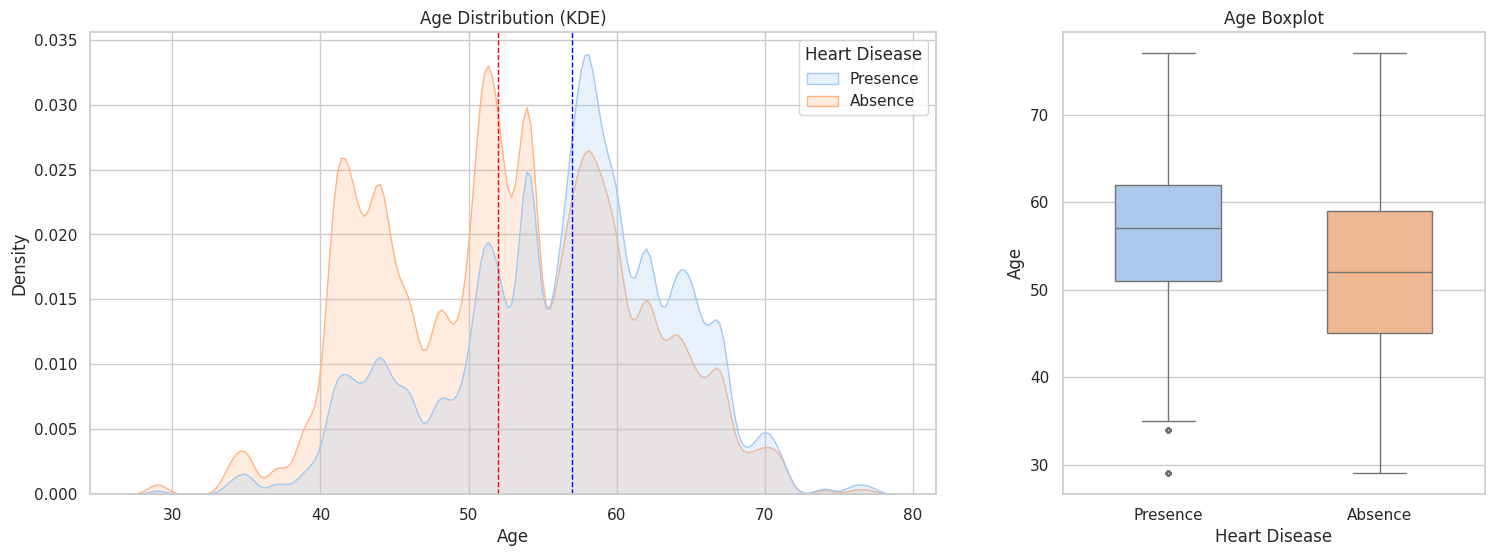

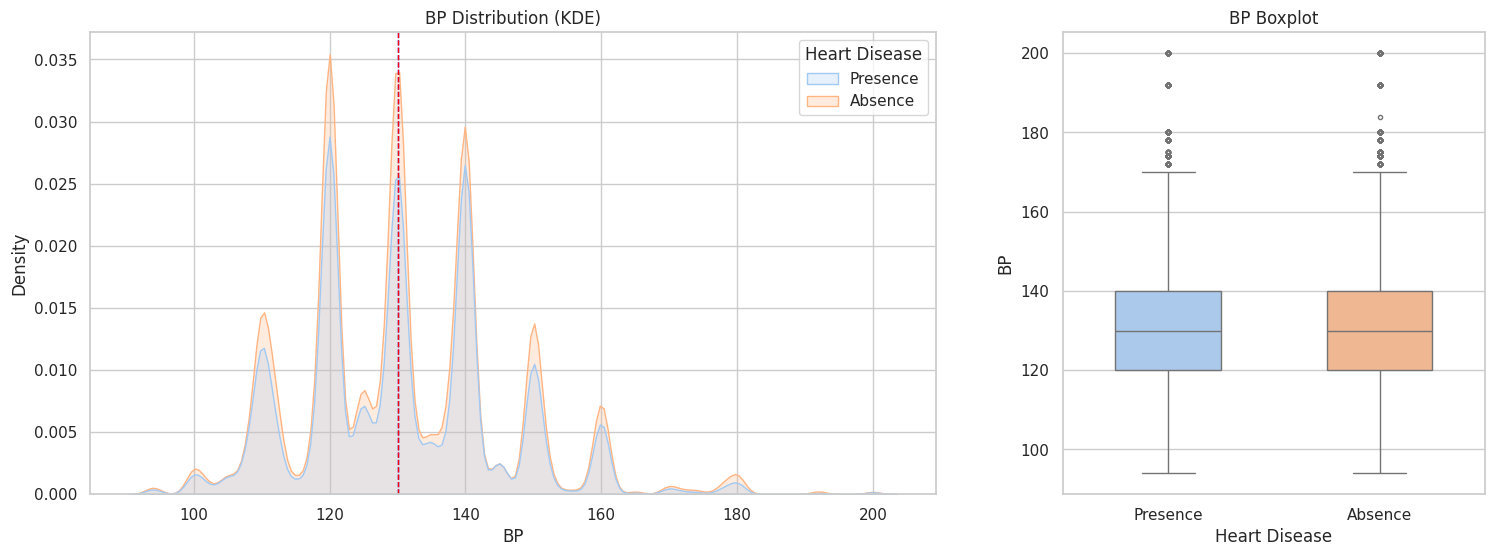

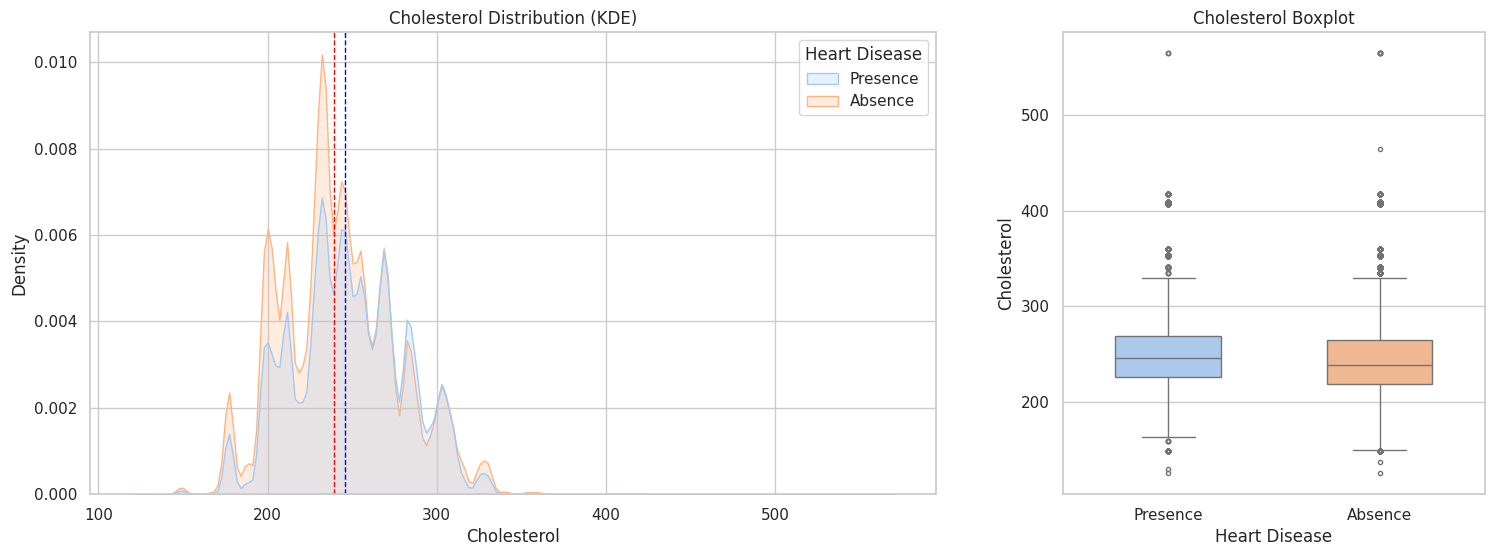

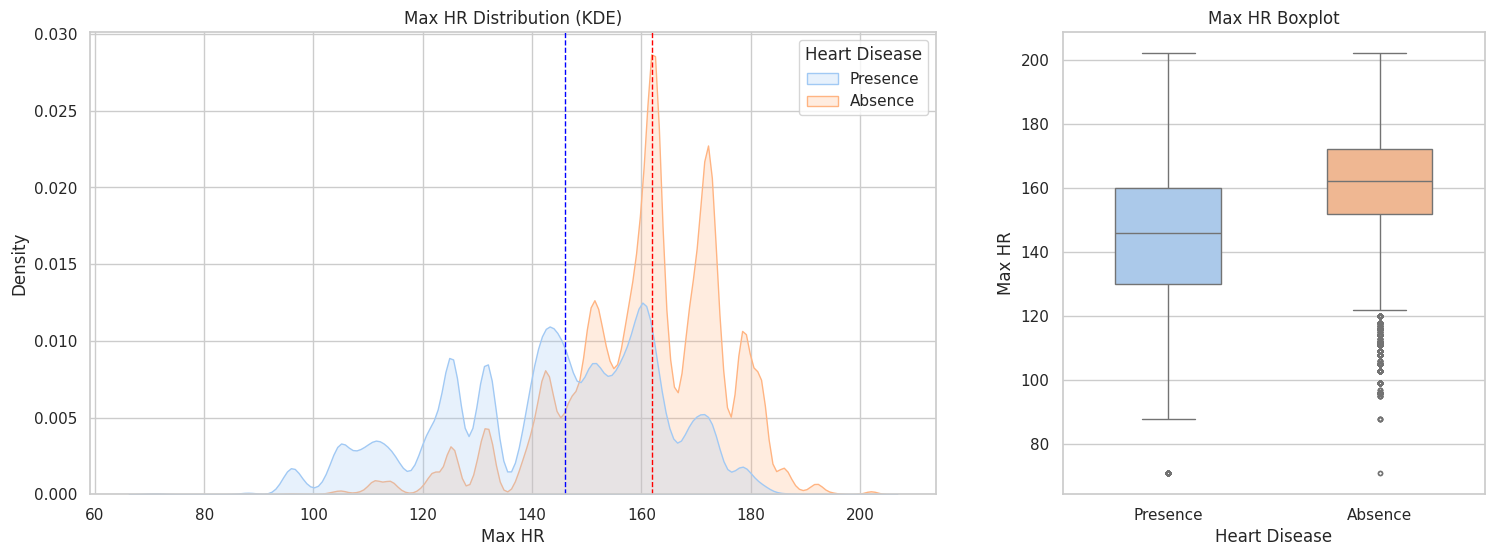

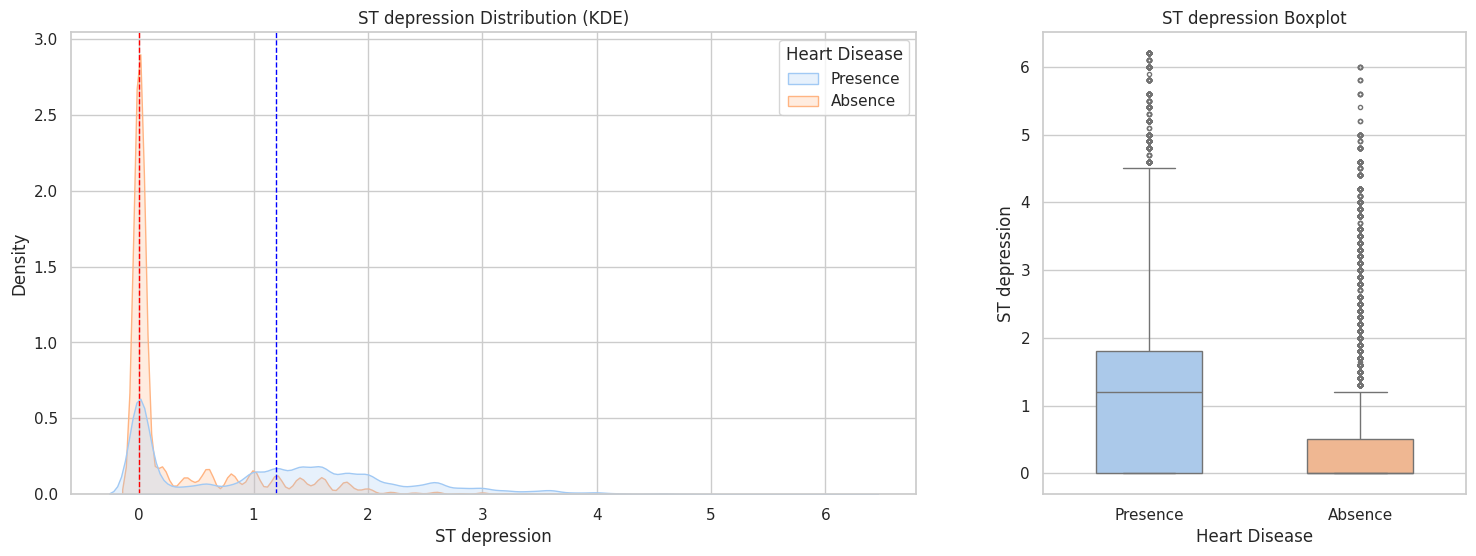

In [9]:
# numerical variable kde-box plot with target
colors = sns.color_palette('pastel')

# train_data[nom_col_list].hist(bins=100, figsize=(16,12))
for _col in nom_col_list:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1]})
    sns.kdeplot(
        data=train_data, x=_col, hue=target_col, ax=axes[0], fill=True, palette=colors[:2])
    mid = train_data[[_col, target_col]].groupby(target_col).quantile(.5).to_dict()[_col]
    axes[0].set_title(f'{_col} Distribution (KDE)', fontsize=12,)
    axes[0].axvline(x=mid['Presence'], color='blue', linestyle='--', linewidth=1, label='Presence_midian')
    axes[0].axvline(x=mid['Absence'], color='red', linestyle='--', linewidth=1, label='Absence_midian')
    
    sns.boxplot(
        data=train_data, x=target_col, y=_col, hue=target_col, ax=axes[1], palette=colors[:2],
        orient='v', width=0.5, linewidth=1, fliersize=3, legend=False)
    axes[1].set_title(f'{_col} Boxplot', fontsize=12)

    plt.show()

In [10]:
target_enc_col = ['Number of vessels fluro', 'Thallium', 'Chest pain type']

train_data[target_col] = LabelEncoder().fit_transform(train_data[target_col]).astype(np.uint8)
global_stats = {'mean': train_data[target_col].mean(), 'median': train_data[target_col].median(), 'count': 0}


X = train_data.iloc[:, :-1]
y = train_data.pop(target_col)

for col in target_enc_col:
    X[col] = X[col].astype(str)
    test_data[col] = test_data[col].astype(str)

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.freq_maps = {}
        self.global_mean_freq = None
        self._feature_names = None 

    def set_output(self, *, transform=None):
        if transform is None or transform in ["pandas", "default"]:
            return self
        raise ValueError(f"Unsupported transform: {transform}")

    def fit(self, X, y=None):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        self._feature_names = list(X_df.columns)
        self.global_mean_freq = 0.0 
        for col in self._feature_names: 
            freqs = X_df[col].value_counts(normalize=True).to_dict()
            self.freq_maps[col] = freqs
        return self

    def transform(self, X, y=None):
        X_df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self._feature_names)
        X_encoded = pd.DataFrame()
        for col in X_df.columns:
            mapping = self.freq_maps.get(col, {})
            X_encoded[col] = X_df[col].map(mapping).fillna(self.global_mean_freq).astype(float)
        X_encoded.columns = [f'frq_enc__{c}' for c in X_encoded.columns] 
        return X_encoded

def target_stats(X, features, st_type, global_stats=global_stats):
    X_stat = pd.DataFrame()
    for c in features:
        c_st_dict = X.groupby(c)[target_col].agg([st_type]).to_dict()[st_type]
        X_stat[c] = X[c].map(c_st_dict).fillna(global_stats[st_type])
    return X_stat

In [11]:
minmax_pipeline = Pipeline(
    [('imputer', SimpleImputer(strategy="median")),
     ('robust_scaling', RobustScaler())]
)
ordinal_pipeline = Pipeline(
    [('imputer', SimpleImputer(strategy="most_frequent")),
     ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=np.int8))]
)
kbins_pipeline = Pipeline(
    [('imputer', SimpleImputer(strategy="median")),
     ('kbins', KBinsDiscretizer(n_bins=10, strategy='uniform', encode='ordinal', random_state=seed))]
)
freq_pipeline = Pipeline(
    [('imputer', SimpleImputer(strategy="median")),
    ('freq', FrequencyEncoder())]
)
log_pipeline = Pipeline(
    [('imputer', SimpleImputer(strategy="median")),
     ('log_trans', FunctionTransformer(func=lambda x: np.log(x + 0.001), feature_names_out='one-to-one')),
     ('robust_scaling', RobustScaler())]
)
square_pipeline = Pipeline(
    [('imputer', SimpleImputer(strategy="median")),
     ('square_trans', FunctionTransformer(func=np.square, feature_names_out='one-to-one')),
     ('robust_scaling', RobustScaler())]
)
cube_pipeline = Pipeline(
    [('imputer', SimpleImputer(strategy="median")),
     ('cube_trans', FunctionTransformer(func=lambda x: np.power(x, 3), feature_names_out='one-to-one')),
     ('robust_scaling', RobustScaler())]
)
sqrt_pipeline = Pipeline(
    [('imputer', SimpleImputer(strategy="median")),
     ('sqrt_trans', FunctionTransformer(func=np.sqrt, feature_names_out='one-to-one')),
     ('robust_scaling', RobustScaler())]
)
cbrt_pipeline = Pipeline(
    [('imputer', SimpleImputer(strategy="median")),
     ('cbrt_trans', FunctionTransformer(func=np.cbrt, feature_names_out='one-to-one')),
     ('robust_scaling', RobustScaler())]
)
median_pipeline_placeholder = Pipeline(
    [('imputer', SimpleImputer(strategy="median")),
     ('median_enc', FunctionTransformer(func=lambda x, features, stats, global_stats: target_stats(x, features, stats, 'median', global_stats), validate=False, feature_names_out='one-to-one'))]
)


In [12]:
preprocessor = ColumnTransformer([
    ("minmax", minmax_pipeline, nom_col_list),
    ("cluster", kbins_pipeline, nom_col_list),
    ("frqn", freq_pipeline, nom_col_list),
    ("ordinal", ordinal_pipeline, cat_col_list),
    ("frqc", freq_pipeline, cat_col_list),
    ("log", log_pipeline, nom_col_list),
    ("square", square_pipeline, nom_col_list),
    ("target_enc", TargetEncoder(smoothing=40, min_samples_leaf=20), target_enc_col),
    ("raw_age", FunctionTransformer(lambda x: x), ["Age"]),
], remainder='passthrough')

In [13]:
def create_interactions(X):
    X = X.copy()
    # 1. RPP (혈압 * 심박수)
    X['HR_times_BP'] = X['minmax__Max HR'] * X['minmax__BP']
    
    # 2. 연령 대비 심박 비율
    X['HR_Age_Ratio'] = X['minmax__Max HR'] / (220 - X['raw_age__Age'] + 1e-6)
    
    # 3. HR & Cholesterol
    X['HR_Chol_Mul'] = X['minmax__Max HR'] * X['minmax__Cholesterol']
    
    # 4. ST_depression & Chest_pain
    X['ST_Chest_Interaction'] = X['minmax__ST depression'] * X['ordinal__Chest pain type']
    # 5. ST depression & Max HR
    X['ST_HR_times'] = X['minmax__ST depression'] * X['minmax__Max HR']
    # 혈압과 심박수 비율
    X['HR_BP_Ratio'] = X['minmax__Max HR'] / (X['minmax__BP'] + 1e-6)
    return X

# 파이프라인에 추가할 변환기
interaction_transformer = FunctionTransformer(create_interactions)

def feature_drop(X):
    X = X.copy()
    # lgbm 중요도에서 100이하 제거
    low_importance_cols = [
        'ordinal__FBS over 120', 
        'cluster__Age', 'cluster__BP', 'cluster__Cholesterol', 'cluster__ST depression', 
        'frqc__frq_enc__FBS over 120', 'frqc__frq_enc__Number of vessels_fluro', 'frqc__frq_enc__Thallium', 'frqc__frq_enc__Exercise angina', 'frqc__frq_enc__EKG results',
    ]
    existing_cols = [c for c in low_importance_cols if c in X.columns]
    return X.drop(columns=existing_cols)
    
# 파이프라인에 추가할 변환기
drop_transformer = FunctionTransformer(feature_drop)

In [14]:
preprocessing_base = Pipeline([
    ('preprocessor', preprocessor),   
    ('interactions', interaction_transformer), 
    ('lowdrop', drop_transformer),
])

In [15]:
# Model
GPU_ACC = True

lr = LogisticRegression()
et = ExtraTreesClassifier()
hgbc = HistGradientBoostingClassifier()
xgb = xgboost.XGBClassifier()
lgbm = lightgbm.LGBMClassifier()
catc = CatBoostClassifier()

# Model space
EstimatorStr = {1: 'lr', 2: 'et', 3: 'hgbc', 4: 'xgb', 5: 'lgbm', 6: 'catc'}
EstimatorMdl = {1: lr,   2: et,   3: hgbc,   4: xgb,   5: lgbm,   6: catc}

In [ ]:
# # ## Tuned hyperparameter sets
# def objective(trial):
#     if est_id == 1:
#         params = {
#             'C': trial.suggest_float('C', 1e-4, 10.0, log=True),
#             'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
#             'solver': 'saga',
#             'max_iter': 1000,
#             'tol': 0.001,
#             # 'l1_ratio': trial.suggest_float('lr_l1_ratio', 0, 1) if trial.params.get('lr_penalty') == 'elasticnet' else None
#         }
#     elif est_id == 2:
#         params = {
#             'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
#             'max_depth': trial.suggest_int('max_depth', 10, 50),
#             'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#             'max_features': trial.suggest_float('max_features', 0.3, 1.0),
#             'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
#         }
#     elif est_id == 3:
#         params = {
#             'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
#             'max_iter': trial.suggest_int('max_iter', 500, 2000),
#             'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 15, 127),
#             'max_depth': trial.suggest_int('max_depth', 5, 20),
#             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 100),
#             'l2_regularization': trial.suggest_float('l2_regularization', 1e-3, 10.0, log=True),
#             'early_stopping': True
#         }
#     elif est_id == 4:
#         params = {
#             'n_estimators': 1500,
#             'max_depth': trial.suggest_int('max_depth', 3, 12),
#             'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
#             'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#             'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#             'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
#             'reg_lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
#             'reg_alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
#             'early_stopping_rounds': 50,
#             'tree_method': 'hist', 
#         }
#     elif est_id == 5:
#         params = {
#             'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
#             'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
#             'num_leaves': trial.suggest_int('num_leaves', 31, 255),
#             'max_depth': trial.suggest_int('max_depth', 5, 10),
#             'min_child_samples': trial.suggest_int('min_child_samples', 100, 500),
#             'colsample_bytree': trial.suggest_float('feature_fraction', 0.4, 0.6),
#             'subsample': trial.suggest_float('bagging_fraction', 0.7, 1.0),
#             'subsample_freq': trial.suggest_int('bagging_freq', 1, 7),
#             'early_stopping_round': 100,
#             'objective': 'binary',
#             'metric': 'auc', 
#             'is_unbalance': True, 
#             'random_state': seed, 
#             'device': 'gpu' if GPU_ACC else 'cpu', 
#             'verbosity': -1,
#             'importance_type': 'gain',
#         }
#     elif est_id == 6:
#         params = {
#             'iterations': 2000,
#             'depth': trial.suggest_int('depth', 4, 10),
#             'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
#             'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
#             'random_strength': trial.suggest_float('random_strength', 1.0, 10.0),
#             'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
#             'boosting_type': 'Plain',
#             'bootstrap_type': 'MVS', # Bernoulli -> MVS 권장 (GPU 효율)
#             'early_stopping_rounds': 50,
#         }
#     model_param = params
#     cv_score = []

#     # skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)
#     X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)

#     # for train_idx, val_idx in skf.split(X, y):
#     #     X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     #     y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     model = deepcopy(EstimatorMdl[est_id])
#     pipeline_copy = deepcopy(preprocessing_base)
#     pipeline_copy.set_output(transform='pandas')
        
#     X_tr = pipeline_copy.fit_transform(X_tr, y_tr)
#     X_val = pipeline_copy.transform(X_val)
#     if est_id == 6:
#         ordinal_columns = make_column_selector(pattern='ordinal|cluster')(X_tr)
#         X_tr[ordinal_columns] = X_tr[ordinal_columns].astype(str).astype('category' if est_id in EST_IDS_W_CAT_FEAT else 'uint8')
#         X_val[ordinal_columns] = X_val[ordinal_columns].astype(str).astype('category' if est_id in EST_IDS_W_CAT_FEAT else 'uint8')
#         params.update({'cat_features': ordinal_columns})
    
#     model.set_params(**model_param)
#     if est_id in EST_IDS_W_EARLYSTOPPING:
#         model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
#     else:
#         model.fit(X_tr, y_tr)
#     preds = model.predict_proba(X_val)[:, 1]   
#     return roc_auc_score(y_val, preds)
#     # preds = model.predict_proba(X_val)[:, 1]
#     # cv_score.append(roc_auc_score(y_val, preds))
#     # return np.mean(cv_score)

In [16]:
lr_params = {
    "C": 0.4015730855842094,
    "penalty": "l1",
    'solver': 'saga',
    'max_iter': 1000,
    'tol': 0.001,
    'random_state': seed, 
    'n_jobs': -1
}
hgbc_params = {
    "learning_rate": 0.0427125950073068,
    "max_iter": 1411,
    "max_leaf_nodes": 39,
    "max_depth": 6,
    "min_samples_leaf": 12,
    "l2_regularization": 0.0011130407805067782,
    'scoring': 'roc_auc', 
    'class_weight': 'balanced', 
    'random_state': seed, 
    'early_stopping': True,
}
lgbm_params ={
    "n_estimators": 3000,
    "learning_rate": 0.012396577620934138,
    "num_leaves": 158,
    "max_depth": 5,
    "min_child_samples": 148,
    "feature_fraction": 0.4229243485116701,
    "bagging_fraction": 0.7423977412122245,
    "bagging_freq": 4,
    'early_stopping_round': 100,
    'objective': 'binary',
    'metric': 'auc', 
    'is_unbalance': False, 
    'random_state': seed, 
    'device': 'gpu' if GPU_ACC else 'cpu', 
    'verbosity': -1,
}
catc_params = {
    'iterations': 3000,
    "depth": 10,
    "learning_rate": 0.0352884492889246,
    "l2_leaf_reg": 3.282062804017597,
    "random_strength": 7.611455519781875,
    "bagging_temperature": 0.6862915363980234,
    'boosting_type': 'Plain',
    'bootstrap_type': 'MVS', # Bernoulli -> MVS 권장 (GPU 효율)
    'early_stopping_rounds': 50,
    'eval_metric': 'AUC', 
    'auto_class_weights': 'Balanced', 
    'random_state': seed, 
    'task_type': 'GPU' if GPU_ACC else 'CPU', 
    'verbose': False,
}
params = {1: lr_params, 3: hgbc_params, 5: lgbm_params, 6: catc_params}

In [ ]:
# ### Find best params
# TUNING = False
# FOLDS = 7

# EST_IDS = [5] # {1: 'lr', 2: 'xtree', 3: 'hgbc', 4: 'xgb', 5: 'lgbm', 6: 'catc'}
# EST_IDS_W_EARLYSTOPPING = [4,5,6]
# EST_IDS_W_CAT_FEAT = [3, 4, 5, 6]


# for est_id in EST_IDS:
#     pipeline = Pipeline([('est', EstimatorMdl[est_id])])
#     best_p = {}
#     skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

#     if TUNING:
#         study = optuna.create_study(direction="maximize")
#         study.optimize(objective, n_trials=30)

#         best_info = {
#             "best_score": study.best_value,
#             "best_params": study.best_params,
#             "model_name": f"{EstimatorStr[est_id]}" # 예시
#         }

#         with open(f"best_config_{EstimatorStr[est_id]}.json", "w") as f:
#             json.dump(best_info, f, indent=4)
        
#         print("Best Parameters:", study.best_params)
#         best_p = study.best_params
#         # model_name = best_p.pop('model_type')
    
#     oof_preds = np.zeros(len(X))
#     # all_importances = []
#     final_test_preds = np.zeros(len(test_data))
#     skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)
    
#     for _id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
#         X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
#         pipeline_copy = deepcopy(preprocessing_base)
#         pipeline_copy.set_output(transform='pandas')

#         X_tr = pipeline_copy.fit_transform(X_tr, y_tr)
#         X_val = pipeline_copy.transform(X_val)
#         test_scaled = pipeline_copy.transform(test_data)

#         if est_id == 6:
#             ordinal_columns = make_column_selector(pattern='ordinal|cluster')(X_tr)
#             X_tr[ordinal_columns] = X_tr[ordinal_columns].astype(str).astype('category' if est_id in EST_IDS_W_CAT_FEAT else 'uint8')
#             X_val[ordinal_columns] = X_val[ordinal_columns].astype(str).astype('category' if est_id in EST_IDS_W_CAT_FEAT else 'uint8')
#             test_scaled[ordinal_columns] = test_scaled[ordinal_columns].astype(str).astype('category' if est_id in EST_IDS_W_CAT_FEAT else 'uint8')
#             # params.update({'cat_features': ordinal_columns})
        
#         # fold_model = LogisticRegression(solver= 'saga', max_iter=1000, tol=0.001, random_state=seed, n_jobs=-1, **best_p)
#         # fold_model = ExtraTreesClassifier(n_jobs=-1, random_state=seed, **best_p)
#         # fold_model = HistGradientBoostingClassifier(scoring='roc_auc', class_weight='balanced', random_state=seed, early_stopping=True, **best_p)
#         # fold_model = xgboost.XGBClassifier(objective='binary:logistic', enable_categorical=True, device='cuda' if GPU_ACC else 'cpu',random_state=seed, eval_metric="auc", **best_p)
#         fold_model = lightgbm.LGBMClassifier(objective='binary', metric='auc', is_unbalance=False, random_state=seed, device ='gpu' if GPU_ACC else 'cpu', verbosity=-1, early_stopping_round= 50, importance_type='gain', **best_p)
#         # fold_model = CatBoostClassifier(eval_metric='AUC', auto_class_weights='Balanced', random_state=seed, task_type='GPU' if GPU_ACC else 'CPU', verbose=False, 
#         #                                 boosting_type='Plain', bootstrap_type='MVS', # Bernoulli -> MVS 권장 (GPU 효율)
#         #                                 early_stopping_rounds=50, **best_p)
#         # fold_model.fit(X_tr, y_tr, eval_set=(X_val, y_val), cat_features=ordinal_columns)
#         fold_model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
#         # fold_model.fit(X_tr, y_tr)

#         val_preds = fold_model.predict(X_val)
#         oof_preds[val_idx] = val_preds
#         final_test_preds += fold_model.predict_proba(test_scaled)[:, 1] / skf.n_splits
        
#         # scores = fold_model.get_booster().get_score(importance_type='gain') # xgb
        
#         importance_df = pd.DataFrame({
#             'Feature': fold_model.feature_name_,
#             'Importance': fold_model.feature_importances_
#         }).sort_values(by='Importance', ascending=False)
#         importance_df.to_csv(f'importance_{_id}.csv') # lgbm
        
#         # importance_df = pd.DataFrame({
#         #     'Feature': fold_model.feature_names_,
#         #     'Importance': fold_model.get_feature_importance()
#         # }).sort_values(by='Importance', ascending=False)
#         # importance_df.to_csv(f'importance_{_id}.csv') # catc
        
#         preds = fold_model.predict_proba(X_val)[:, 1]   
#         fold_score = roc_auc_score(y_val, preds)
#         # fold_score = fold_model.score(X_val, y_val)
#         print(f"Fold {_id}  Score: {fold_score:.4f}")
    
#     oof_accuracy = np.mean(oof_preds == y)
#     print(f"\n[최종 결과] OOF 전체 정확도: {oof_accuracy:.4f}")
#     submission['Heart Disease'] = final_test_preds
#     submission.to_csv(f'submission_{EstimatorStr[est_id]}.csv', index=False)

## 1차 model optuna tuning 
oof-optuna로 parameter tuning하고 feature encoding을 하려했으나 7(fold) * (params 곱연산) * (30 trial)로 runtime error가 걸림
- lr: .94972
- et: .95095
- hgbc: .95340
- xgb: .94851
- lgbm: .95357
- cat: .95253
  
## 1차 essemble
상위권 3개 hgbc, lgbm, cat를 기준으로 잡고, lr모델을 약간의 첨가하는 방식을 선택
- Score-based Weight w.lr
  - 위의 모델 점수를 비례하는 가중치를 줘서 앙상블
  - 3모델 : .95338
  - 3모델+lr : .95334
- Simple Rank Weight w.lr
  - 위의 모델 점수를 랭크로 봐서 앙상블
  - 3모델 : .95339
  - 3모델+lr : .95335
- Top Tier Weight w.lr
  - 가장 높은 점수의 모델의 가중치를 50%이상 주는 앙상블
  - 3모델 : .95346
  - 3모델+lr : .95344
- meta model
  - 3개 모델의 oof값을 lr에 훈련
  - .95332
- lr이 포함이 되면 안좋고, 3개 모델이 균등보다는 lgbm에 집중하는게 좋아보임
  
## 2차 model optuna
1. square, log를 제외한 제곱근, 3제곱근, 3제곱의 변환제거
2. create_interactions 통해 변수 추가
3. feature_drop를 통해 lgbm의 oof의 FE의 하위 10%를 제거
4. target encoder 추가
- .95326 -> .95355 증가

## 2차 model essemble
- 위의 1차 모델 lgbm하고 2차 lgbm essemble
- .0002차이 여서 동일 가중치로 essemble
  - .95358
- roc-auc여서 rankdata로 essemble
  - .95359

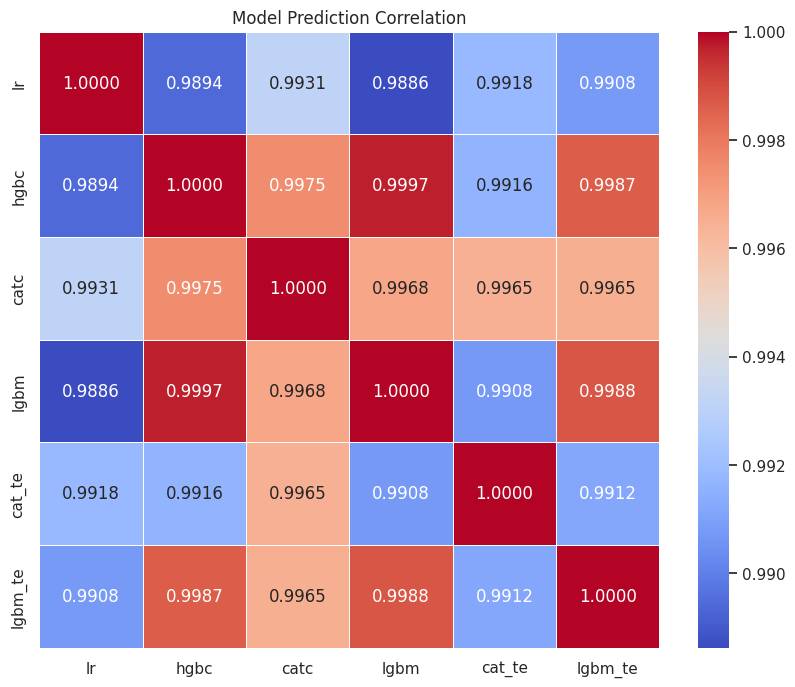

In [17]:
sub_folder = '/kaggle/input/datasets/domchitdomchit/submission'
sub_te_folder = '/kaggle/input/datasets/domchitdomchit/submission-te'
sub_file_list = os.listdir(sub_folder)
sub_te_file_list = os.listdir(sub_te_folder)
sub_dict = {}
for _file in sub_file_list:
    model_name = _file.split('.')[0][11:]
    sub_dict[model_name] = pd.read_csv(os.path.join(sub_folder, _file))['Heart Disease'].values
for _file in sub_te_file_list:
    if 'te' in _file:
        model_name = _file.split('.')[0][11:]
    else:
        model_name = _file.split('.')[0][11:] + '_te'
    sub_dict[model_name] = pd.read_csv(os.path.join(sub_te_folder, _file))['Heart Disease'].values


corr_matrix = pd.DataFrame(sub_dict).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5)
plt.title('Model Prediction Correlation')
plt.show()

In [ ]:
# FOLDS = 7
# EST_IDS = [5] # {1: 'lr', 2: 'xtree', 3: 'hgbc', 4: 'xgb', 5: 'lgbm', 6: 'catc'}
# oof_preds = dict()
# final_test_preds = dict()

# for est_id in EST_IDS:
#     oof_preds[est_id] = np.zeros(len(X))
#     final_test_preds[est_id] = np.zeros(len(test_data))
#     skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)
#     for _id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
#         X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
#         pipeline_copy = deepcopy(preprocessing_base)
#         pipeline_copy.set_output(transform='pandas')
    
#         X_tr = pipeline_copy.fit_transform(X_tr, y_tr)
#         X_val = pipeline_copy.transform(X_val)
#         test_scaled = pipeline_copy.transform(test_data)
    
#         if est_id == 6:
#             ordinal_columns = make_column_selector(pattern='ordinal|cluster')(X_tr)
#             X_tr[ordinal_columns] = X_tr[ordinal_columns].astype(str).astype('category')
#             X_val[ordinal_columns] = X_val[ordinal_columns].astype(str).astype('category')
#             test_scaled[ordinal_columns] = test_scaled[ordinal_columns].astype(str).astype('category')
        
#         fold_model = deepcopy(EstimatorMdl[est_id])
#         fold_model.set_params(**params[est_id])
#         if est_id in [1, 3]:
#             fold_model.fit(X_tr, y_tr)
#         elif est_id == 6:
#             fold_model.fit(X_tr, y_tr, eval_set=(X_val, y_val), cat_features=ordinal_columns)
#         else:
#             fold_model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
    
#         val_preds = fold_model.predict(X_val)
#         oof_preds[est_id][val_idx] = val_preds
#         final_test_preds[est_id] += fold_model.predict_proba(test_scaled)[:, 1] / skf.n_splits
        
#         fold_score = fold_model.score(X_val, y_val)
#         print(f"Fold {_id}  Score: {fold_score:.4f}")

In [ ]:
# # blending - before lgbm(.3) atfer lgbm(.7)
# sub_lgbm = final_test_preds[5] * .7 + sub_dict['lgbm'] * .3
# submission_lgbm = deepcopy(submission)
# submission_lgbm['Heart Disease'] = sub_lgbm
# submission_lgbm.to_csv(f'submission_sub_lgbm.csv', index=False)

In [ ]:
# # Score-based Weight w.lr
# sub_SBW = 0.346 * final_test_preds[5] + 0.339 * final_test_preds[3] + 0.315 * final_test_preds[6]
# submission_SBW = deepcopy(submission)
# submission_SBW['Heart Disease'] = sub_SBW
# submission_SBW.to_csv(f'submission_sub_SBW.csv', index=False)

# # w LR
# sub_SBWwLR = 0.326 * final_test_preds[5] + 0.323 * final_test_preds[3] + 0.301 * final_test_preds[6] + 0.05 * final_test_preds[1]
# submission_SBWwLR = deepcopy(submission)
# submission_SBWwLR['Heart Disease'] = sub_SBWwLR
# submission_SBWwLR.to_csv(f'submission_sub_SBWwLR.csv', index=False)

In [ ]:
# # Simple Rank Weight w.lr
# sub_SRW = 0.36 * final_test_preds[5] + 0.34 * final_test_preds[3] + 0.30 * final_test_preds[6]
# submission_SRW = deepcopy(submission)
# submission_SRW['Heart Disease'] = sub_SRW
# submission_SRW.to_csv(f'submission_sub_SRW.csv', index=False)

# # w LR
# sub_SRWwLR = 0.35 * final_test_preds[5] + 0.32 * final_test_preds[3] + 0.28 * final_test_preds[6] + 0.05 * final_test_preds[1]
# submission_SRWwLR = deepcopy(submission)
# submission_SRWwLR['Heart Disease'] = sub_SRWwLR
# submission_SRWwLR.to_csv(f'submission_sub_SRWwLR.csv', index=False)

In [ ]:
# # Top Tier Weight
# sub_TTW = 0.60 * final_test_preds[5] + 0.20 * final_test_preds[3] + 0.20 * final_test_preds[6]
# submission_TTW = deepcopy(submission)
# submission_TTW['Heart Disease'] = sub_TTW
# submission_TTW.to_csv(f'submission_sub_TTW.csv', index=False)

# # w LR
# sub_TTWwLR = 0.60 * final_test_preds[5] + 0.20 * final_test_preds[3] + 0.15 * final_test_preds[6] + 0.05 * final_test_preds[1]
# submission_TTWwLR = deepcopy(submission)
# submission_TTWwLR['Heart Disease'] = sub_TTWwLR
# submission_TTWwLR.to_csv(f'submission_sub_TTWwLR.csv', index=False)

In [ ]:
# # stack
# X_meta = pd.DataFrame([oof_preds[5], oof_preds[3], oof_preds[6]]).T
# y_meta = deepcopy(y)

# meta_model = LogisticRegression(C=1.0, solver='lbfgs')
# meta_model.fit(X_meta, y_meta)

# X_test_meta = pd.DataFrame([final_test_preds[5], final_test_preds[3], final_test_preds[6]]).T
# meta_test_prob = meta_model.predict_proba(X_test_meta)[:, 1]
# submission_meta = deepcopy(submission)
# submission_meta['Heart Disease'] = meta_test_prob
# submission_meta.to_csv(f'submission_sub_stack.csv', index=False)

# submission_metalr = deepcopy(submission)
# submission_metalr['Heart Disease'] = 0.95 * meta_test_prob + .05 * final_test_preds[1]
# submission_metalr.to_csv(f'submission_sub_stackwLR.csv', index=False)

In [ ]:
# from scipy.stats import rankdata
# new_lgbm = rankdata(sub_dict['lgbm'])/(len(sub_dict['lgbm']) + 1)
# new_lgbm_te = rankdata(sub_dict['lgbm_te'])/(len(sub_dict['lgbm_te']) + 1)
# new_cat_te = rankdata(sub_dict['cat_te'])/(len(sub_dict['cat_te']) + 1)

# final_rank_blend = (new_lgbm_te * 0.5) + (new_lgbm * 0.5)
# submission['Heart Disease'] = final_rank_blend
# submission.to_csv(f'submission_sub_Rb_lgbm.csv', index=False)

# final_rank_blend = (new_lgbm_te * 0.45) + (new_lgbm * 0.5) + (new_cat_te * 0.05)
# submission['Heart Disease'] = final_rank_blend
# submission.to_csv(f'submission_sub_Rb_.csv', index=False)